In [49]:
from copy import deepcopy
import minhash
from loadimdbdata import table_pairs
import random
import time
from math import factorial
from datetime import datetime
from scipy.special import comb
from scipy import linspace
from statistics import median
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## CALCULATING CDF AND VALUE THRESHOLD GIVEN CDF ##

In [4]:
# helper function for calculating cdf

def unit_step_function(a, t):
    if t < a:
        return 0
    else:
        return 1

In [5]:
# given a number of random variables with uniform distribution, 
# find probability that their sum = given target value

def cdf(n, t):
    if n <= 0:
        return 0
    else:
        mySum = 0.0
        for i in range(n+1):
            mySum += ((-1)**i * comb(n, i) * ((t-i)**n)/factorial(n) * unit_step_function(i, t))
        return mySum
    
def cdf_multiple_values(n, t):
    cdf_values = []
    for target_value in t:
        cdf_values.append(cdf(n, target_value))
    return cdf_values

In [6]:
# given a number of random variables with uniform distribution,
# find the threshold for their sum at a certain probability

def find_value_threshold(n, cdf_value):
    cdf_value *= 1.0
    t_index = 0
    while cdf(n, t_index) < cdf_value:
        t_index+=1
    if cdf_value -.001 <= cdf(n, t_index) <= cdf_value + .001:
        return t_index
    else:
        lower_bound = t_index-1.0
        bound_difference = 1.0
        midpoint = lower_bound + bound_difference/2.0
        bound_difference/=2.0
        midpoint_cdf = cdf(n, midpoint)
        while not cdf_value - .01 <= midpoint_cdf <= cdf_value+.01:
            if midpoint_cdf > cdf_value:
                midpoint -= bound_difference/2.0
            else:
                midpoint += bound_difference/2.0
            midpoint_cdf = cdf(n, midpoint)
            bound_difference /= 2.0
        return midpoint

In [7]:
def cdf_plotter(n, multiple_n = False):
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.ylabel('Probability')
    plt.xlabel('Sum')
    if multiple_n:
        for number in n:
            cdf_plotter(number)
    else:
        x = linspace(0, n+2, 500)
        plt.plot(x, cdf_multiple_values(n,x), label='n = {i}'.format(i=n))
        plt.legend(loc='best')

In [8]:
def threshold_value_plotter(n, cdf, multiple_n = False, multiple_cdf = False):
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.ylabel('Probability')
    plt.xlabel('Sum')
    if multiple_n:
        for n_value in n:
            x = linspace(0, n_value+2, 500)
            plt.plot(x, cdf_multiple_values(n_value,x), label='n = {i}'.format(i=n_value))
            plt.legend(loc='best')
            if multiple_cdf:
                for cdf_value in cdf:
                    x = find_value_threshold(n_value, cdf_value)
                    y = cdf_value
                    plt.plot(x, y, marker='o', color='black', label='t = {i}'.format(i=x))
            else:
                x = find_value_threshold(n_value, cdf)
                y = cdf
                plt.plot(x, y, market='o', color='black', label='t = {i}'.format(i=x))
    else:
        x = linspace(0, n+2, 500)
        plt.plot(x, cdf_multiple_values(n,x), label='n = {i}'.format(i=n))
        plt.legend(loc='best')
        if multiple_cdf:
            for cdf_value in cdf:
                x = find_value_threshold(n, cdf_value)
                y = cdf_value
                plt.plot(x, y, marker='o', color='black', label='t = {i}'.format(i=x))
        else:
            x = find_value_threshold(n, cdf)
            y = cdf
            plt.plot(x, y, marker='o', color='black', label='t = {i}'.format(i=x))
        

In [9]:
## PERFORMING A NATURAL JOIN USING A CLASSIC HASH JOIN ##

In [10]:
# helper function for edge case where tables have no common attributes

def cartesian_product(r,s):
    output = []
    for r_entry in r:
        for s_entry in s:
            r_copy = r_entry.copy()
            r_copy.update(s_entry)
            output.append(r_copy)
    return output

In [11]:
# hash join function for two tables

def classic_hash_join(r, s):
    if len(s) == 0 or len(r) == 0:
        return []
    
    r_attributes = r[0].keys()
    s_attributes = s[0].keys()
    common_attributes = list(filter(lambda ra: ra in s_attributes, r_attributes))
    if len(common_attributes) > 0:
        s_unique_attributes = list(filter(lambda sa: sa not in common_attributes, s_attributes))
        hashtable = {}
        hashtable_keys = []
        hashkey = ""
        
        #build hash table
        row_index = 0
        for entry in r:
            hashkey = "".join([entry[attribute] for attribute in common_attributes if attribute in entry.keys()])
            if hashkey not in hashtable_keys:
                hashtable[hashkey] = [row_index]
                hashtable_keys.append(hashkey)
            else:
                hashtable[hashkey].append(row_index)
            hashkey = ""
            row_index+=1
        
        #join
        output = []
        for entry in s:
            hashkey = "".join([entry[attribute] for attribute in common_attributes if attribute in entry.keys()])
            if hashkey in hashtable_keys:
                filtered_dict = {k:v for (k,v) in entry.items() if k in s_unique_attributes}
                for r_index in hashtable[hashkey]:
                    new_entry = (r[r_index].copy())
                    new_entry.update(filtered_dict)
                    output.append(new_entry)
            hashkey=""
            
        return output
    else:
        return cartesian_product(r,s)

In [12]:
# wrapper function for performing hash joins on given list of tables

def natural_join(tables):
    l1 = tables[0]
    for i in range(1, len(tables)):
        l1 = classic_hash_join(l1, tables[i])
    return l1

In [13]:
## FETCHING DATA FOR PERFORMING JOINS WITH HASHED AND RANDOM SAMPLING ##

In [14]:
# helper function for normalizing hash values to [0,1]

def normalize(lower, upper, value):
    return (float(value) - float(lower)) / (float(upper) - float(lower))

In [15]:
# helper function for cleaning tables after hashing join attribute values

def remove_hashsum_key(tables):
    for table in tables:
        for entry in table:
            if "hash sum" in entry.keys():
                del entry["hash sum"]
                
    return tables

In [16]:
# function to get data for performing joins with hashed and random sampling,
# given a list of tables

def cdfjoin(tables, sampling_threshold, random_threshold=0.0):
    if len(tables) <= 1:
        return tables
    else:
        attrs = {}
        join_attrs = []
        
        #find join attributes
        for i in range(len(tables)):
            table = tables[i]
            for table_key in table[0].keys():
                if table_key in attrs.keys(): attrs[table_key].append(i)
                else: attrs[table_key] = [i]
        join_attrs = [k for k,v in attrs.items() if len(v) > 1]
        
        #generate hash functions for each join_attr
        hash_functions = minhash._generate_hash_fns(len(join_attrs))
        attrs_hash_dict = {join_attrs[i]: hash_functions[i] for i in range(len(hash_functions))}
        
        #copy tables
        tables_copy = []
        for table in tables:
            tables_copy.append(deepcopy(table))
        
        #calculate hash sum for each entry in each table
        for table in tables_copy:
            table_attrs = [key for key in table[0].keys() if key in join_attrs]
            norm_hashed_table = {}
            hashed_table = {}
            hashed_table = {attr: minhash._min_hash([attr], table, attrs_hash_dict[attr]) for attr in table_attrs}
            for k,v in hashed_table.items():
                norm_v = {normalize(0, minhash.NEXTPRIME-1, v1): v2 for v1, v2 in v.items()}
                norm_hashed_table[k] = norm_v
            for i in range(len(table)):
                entry = table[i]
                hash_scores = []
                for k, v in norm_hashed_table.items():
                    for v1, v2 in v.items():
                        if i in v2:
                            hash_scores.append(v1)
                            break
                entry["hash sum"] = sum(hash_scores)
        
        #filter for all entries whose cdf <= sampling probability
        filtered_tables = []
        start = time.time()
        for i in range(len(tables)):
            table = tables_copy[i]
            filtered_table = []
            if "hash sum" in table[0].keys():
                n_join_attrs = len([i for i in table[0].keys() if i in join_attrs])
                for entry in table:
                    if cdf(n_join_attrs, entry["hash sum"]) <= sampling_threshold:
                        filtered_table.append(entry)
            else:
                filtered_table = table
            if len(filtered_table) > 0:
                filtered_tables.append(filtered_table)
            else:
                filtered_tables = []
                break
        filtered_time = time.time() - start        

                
        #filter for all entries whose cdf > random probability
        random_tables = []
        start = time.time()
        for i in range(len(tables)):
            table = tables_copy[i]
            if random_threshold == 0.0:
                random_threshold = random.uniform(0,1)
            random_table = []
            if "hash sum" in table[0].keys():
                n_join_attrs = len([i for i in table[0].keys() if i in join_attrs])
                for entry in table:
                    if random_threshold < cdf(n_join_attrs, entry["hash sum"]):
                        random_table.append(entry)
            else:
                random_table = table
            if len(random_table) > 0:
                random_tables.append(random_table)
            else:
                random_tables = []
                break
        random_time = time.time() - start
        
        if filtered_tables == []:
            joined_filtered_tables = []
        else:
            filtered_tables = remove_hashsum_key(filtered_tables)
            start = time.time()
            joined_filtered_tables = natural_join(filtered_tables)
            filtered_time += time.time() - start
            
        if random_tables == []:
            joined_random_tables = []
        else:
            random_tables = remove_hashsum_key(random_tables)
            start = time.time()
            joined_random_tables = natural_join(random_tables)
            random_time += time.time() - start
            
        return [(joined_filtered_tables, filtered_time), (joined_random_tables, random_time)]

In [17]:
## PLOTTING DATA ON JOINED TABLE SIZE AND RUNTIME FOR HASHED AND RANDOM SAMPLING ##

In [80]:
# helper function for fetching data on multiple values

def get_cdfjoin_plot_data(tables, x_values, size = True, runtime = True):
    cdfjoin_data = []
    for threshold in x_values:
        cdfjoin_result = cdfjoin(tables, threshold)
        if size and runtime:
            cdfjoin_data.append([(len(cdfjoin_result[0][0]), cdfjoin_result[0][1]),
                                (len(cdfjoin_result[1][0]), cdfjoin_result[1][1])])
        elif size and not runtime:
            cdfjoin_data.append([(len(cdfjoin_result[0][0]), None), (len(cdfjoin_result[1][0]), None)])
        elif not size and runtime:
            cdfjoin_data.append([(None, cdfjoin_result[0][1]), (None, cdfjoin_result[1][1])])
            
    return cdfjoin_data

In [81]:
def display_cdfjoin_plots(tables, size = True, runtime = True):
    if not size and not runtime:
        print("Error: Select at least one of the following types of data to display: size, runtime")
        
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
        fig = plt.subplots_adjust(wspace=.5)
        x = linspace(0, 1, 100)
        cdfjoin_plot_data = get_cdfjoin_plot_data(tables, x, size, runtime)
        
        if size:
            outputsize_hashed = [i[0] for [(i),(j)] in cdfjoin_plot_data]
            outputsize_random = [j[0] for [(i),(j)] in cdfjoin_plot_data]
            ax1.plot(x, outputsize_hashed, label='Hashed sampling')
            ax1.plot(x, outputsize_random, label='Random sampling')
            ax1.legend(loc='best')
            ax1.set_xlabel('Sampling Threshold')
            ax1.set_ylabel('Output size')
            ax1.set_title('Output size vs. Sampling Threshold')
        
        if runtime:
            runtime_hashed = [i[1] for [(i),(j)] in cdfjoin_plot_data]
            runtime_random = [j[1] for [(i),(j)] in cdfjoin_plot_data]
            ax2.plot(x, runtime_hashed, label='Hashed sampling')
            ax2.plot(x, runtime_random, label='Random sampling')
            ax2.legend(loc='best')
            ax2.set_xlabel('Sampling Threshold')
            ax2.set_ylabel('Runtime')
            ax2.set_title('Runtime vs. Sampling Threshold')

In [116]:
def display_cdfjoin_plots_1000(tables, size = True, runtime = True):
    if not size and not runtime:
        print("Error: Select at least one of the following types of data to display: size, runtime")
        
    else:
        x = linspace(0, 1, 100)
        size_hashed_data_1000 = {}
        size_random_data_1000 = {}
        runtime_hashed_data_1000 = {}
        runtime_random_data_1000 = {}
        
#         gathering data for 1000 trials
        num_trials = 1000
        for i in range(num_trials): 
            trial_data = get_cdfjoin_plot_data(tables, x, size, runtime)
            for j in range(len(x)):
                x_value = x[j]
                trial_values = trial_data[j]
                if size:
                    if x_value in size_hashed_data_1000.keys():
                        size_hashed_data_1000[x_value].append(trial_values[0][0])
                        size_random_data_1000[x_value].append(trial_values[1][0])
                    else:
                        size_hashed_data_1000[x_value] = [trial_values[0][0]]
                        size_random_data_1000[x_value] = [trial_values[1][0]]

                if runtime:
                    if x_value in runtime_hashed_data_1000.keys():
                        runtime_hashed_data_1000[x_value].append(trial_values[0][1])
                        runtime_random_data_1000[x_value].append(trial_values[1][1])
                    else:
                        runtime_hashed_data_1000[x_value] = [trial_values[0][1]]
                        runtime_random_data_1000[x_value] = [trial_values[1][1]]
                    
            
#         organizing data for each trial by x-value (sampling threshold)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
        fig = plt.subplots_adjust(wspace=.5)
        
        if size:
            size_hashed_data = []
            size_random_data = []
            for k,v in size_hashed_data_1000.items():
                size_hashed_data.append(median(v))
            for k,v in size_random_data_1000.items():
                size_random_data.append(median(v))
            ax1.plot(x, size_hashed_data, label='Hashed sampling')
            ax1.plot(x, size_random_data, label='Random sampling')
            ax1.legend(loc='best')
            ax1.set_xlabel('Sampling Threshold')
            ax1.set_ylabel('Output size')
            ax1.set_title('Output size vs. Sampling Threshold')
                
                
        if runtime:
            runtime_hashed_data = []
            runtime_random_data = []
            for k,v in runtime_hashed_data_1000.items():
                runtime_hashed_data.append(median(v))
            for k,v in runtime_random_data_1000.items():
                runtime_random_data.append(median(v))
            ax2.plot(x, runtime_hashed_data, label='Hashed sampling')
            ax2.plot(x, runtime_random_data, label='Random sampling')
            ax2.legend(loc='best')
            ax2.set_xlabel('Sampling Threshold')
            ax2.set_ylabel('Runtime')
            ax2.set_title('Runtime vs. Sampling Threshold')

In [ ]:
display_cdfjoin_plots_1000(table_pairs[12], True, True)

In [ ]:
display_cdfjoin_plots(table_pairs[12], True, True)

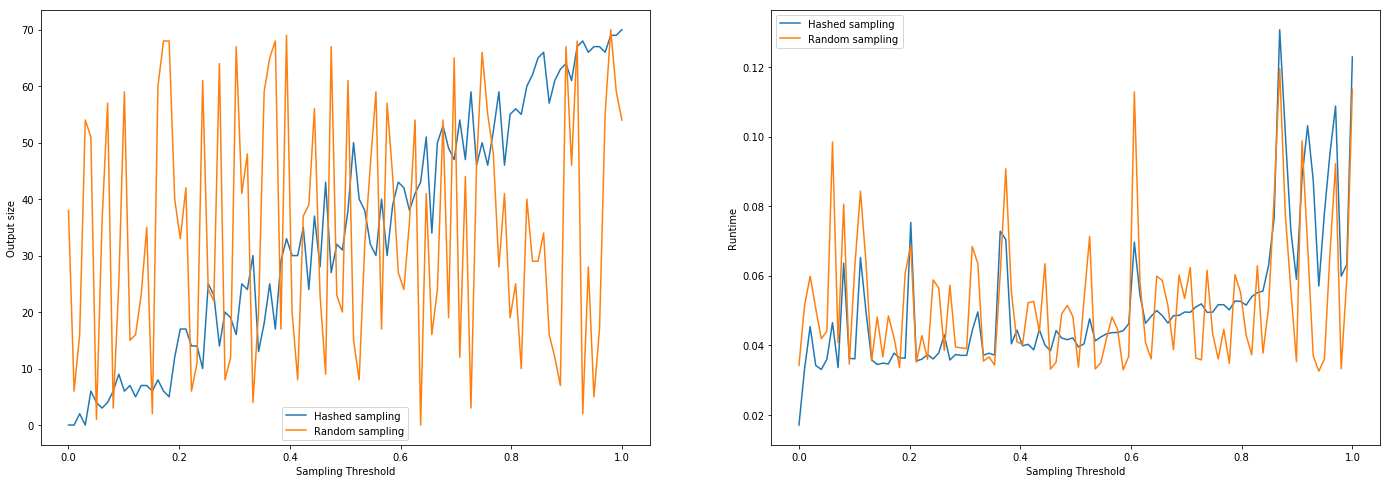

In [33]:
plots_wrapper(table_pairs[12])